#  Assignment 3 - Reproducibility

## Contributers:


#### Reni Koci (renik98) 
#### Viktoria Voucheva (vouchev00)
#### Muhammad Furqan Rafique (rafim96)

## <center>1. Reproducible Model Training</center> 

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# bivariate analysis
import scipy.stats as stats
from scipy.stats import chi2_contingency

# modeling
from sklearn.model_selection import train_test_split,KFold 
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# classification evaluations
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
df_original = pd.read_csv("SouthGermanCredit.asc", sep=" ")

In [3]:
# rename columns
df_original.rename(columns={
    'laufkont': 'status',
    'laufzeit': 'duration',
    'moral': 'credit_history',
    'verw': 'purpose',
    'hoehe': 'amount',
    'sparkont': 'savings',
    'beszeit': 'employment_duration',
    'rate': 'installment_rate',
    'famges': 'personal_status_sex',
    'buerge': 'other_debtors',
    'wohnzeit': 'present_residence',
    'verm': 'property',
    'alter': 'age',
    'weitkred': 'other_installment_plans',
    'wohn': 'housing',
    'bishkred': 'number_credits',
    'beruf': 'job',
    'pers': 'people_liable',
    'telef': 'telephone',
    'gastarb': 'foreign_worker',
    'kredit': 'credit_risk',
}, inplace=True)

--- 
### <b><i> Attribute information 

| Column      | Description 
| :---        |    :----  
| status      | status of the debtor's checking account with the bank (categorical)       
| duration   | credit duration in months (quantitative)         
| credit_history   | history of compliance with previous or concurrent credit contracts (categorical)         
| purpose   | purpose for which the credit is needed (categorical)                
| amount   | credit amount in DM (quantitative; result of monotonic transformation; actual data and type of transformation unknown)   
| savings   | debtor's savings (categorical)         
| employment_duration   | duration of debtor's employment with current employer (ordinal; discretized quantitative)         
| installment_rate   | credit installments as a percentage of debtor's disposable income (ordinal; discretized quantitative)         
| personal_status_sex   | combined information on sex and marital status; categorical; sex cannot be recovered from the variable, because male singles and female non-singles are coded with the same code (2); female widows cannot be easily classified, because the code table does not list them in any of the female categories         
| other_debtors   | Is there another debtor or a guarantor for the credit? (categorical)         
| present_residence   | length of time (in years) the debtor lives in the present residence (ordinal; discretized quantitative)         
| property   | the debtor's most valuable property, i.e. the highest possible code is used. Code 2 is used, if codes 3 or 4 are not applicable and there is a car or any other elevant property that does not fall under variable sparkont. (ordinal)         
| age   | age in years (quantitative)         
| other_installment_plans   | installment plans from providers other than the credit-giving bank (categorical)         
| housing   | type of housing the debtor lives in (categorical)                 
| number_credits   | number of credits including the current one the debtor has (or had) at this bank (ordinal, discretized quantitative); contrary to Fahrmeir and HamerleÃ¢â‚¬â„¢s (1984) statement, the original data values are not available.                 
| job   | quality of debtor's job (ordinal)                 
| people_liable   | number of persons who financially depend on the debtor (i.e., are entitled to maintenance) (binary, discretized quantitative)                 
| telephone   | Is there a telephone landline registered on the debtor's name? (binary; remember that the data are from the 1970s)                 
| foreign_worker   | Is the debtor a foreign worker? (binary)             
| credit_risk   | Has the credit contract been complied with (good) or not (bad) ? (binary)      |

---

In [4]:
df_original.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


In [5]:
# copy of og df
df = df_original.copy()

In [6]:
# status
status_dict = {
    1 :  'no checking account',
    2 : '< 0 DM',
    3 : '0<= ... < 200 DM',
    4 : '>= 200 DM'
}

# credit_history
ch_dict = {
    0 : 'delay in paying off in the past',
    1 : 'critical account/other credits elsewhere',
    2 : 'no credits taken/all credits paid back duly',
    3 : 'existing credits paid back duly till now',
    4 : 'all credits at this bank paid back duly',
}


# purpose 
purp_dict = {
    0 : 'others',
    1 : 'car (new)',
    2 : 'car (used)',
    3 : 'furniture/equipment',
    4 : 'radio/television',
    5 : 'domestic appliances',
    6 : 'repairs',
    7 : 'education',
    8 : 'vacation',
    9 : 'retraining',
    10 : 'business',
}


# savings
savings_dict = {
    1 : 'unknown/no savings account',
    2 : '<  100 DM',
    3 : '100 <= ... <  500 DM',
    4 : '500 <= ... < 1000 DM',
    5 : '>= 1000 DM'
}


# employment_duration
employment_duration_dict = {
    1 : 'unemployed',
    2 : '< 1 yr',
    3 : '1 <= ... < 4 yrs',
    4 : '4 <= ... < 7 yrs',
    5 : '>= 7 yrs'
}


# installment_rate 
installment_rate_dict = {
    1 : '>= 35',
    2 : '25 <= ... < 35',
    3 : '20 <= ... < 25',
    4 : '< 20'
}


# personal_status_sex 
personal_status_sex_dict = {
    1 : 'male : divorced/separated',
    2 : 'female : non-single or male : single',
    3 : 'male : married/widowed',
    4 : 'female : single'
}


# other_debtors 
other_debtors_dict = {
    1 : 'none',
    2 : 'co-applicant',
    3 : 'guarantor'
}

# present_residence 
present_residence_dict = {
    1 : '< 1 yr',
    2 : '1 <= ... < 4 yrs',
    3 : '4 <= ... < 7 yrs',
    4 : '>= 7 yrs',
}

# property 
property_dict = {
    1 : 'unknown / no property',
    2 : 'car or other',
    3 : 'building soc. savings agr./life insurance',
    4 : 'real estate',
}

# other_installment_plans 
other_installment_plans_dict = {
    1 : 'bank',
    2 : 'stores',
    3 : 'none'
}

# housing 
housing_dict = {
    1 : 'for free',
    2 : 'rent',
    3 : 'own'
}

# number_credits 
number_credits_dict = {
    1 : '1',
    2 : '2-3',
    3 : '4-5',
    4 : '>= 6'
}

# people_liable 
people_liable_dict = {
    1 : '3 or more',
    2 : '0 to 2'
}

# telephone 
telephone_dict = {
    1 : 'unemployed/unskilled - non-resident  ',
    2 : 'yes (under customer name)'
}

# job 
job_dict = {
    1 : 'no',
    2 : 'unskilled - resident',
    3 : 'skilled employee/official',
    4 : 'manager/self-empl./highly qualif. employee'
}

# foreign_worker 
foreign_worker_dict = {
    1 : 'yes',
    2 : 'no'
}

# credit_risk -> Since this is our y-var lets keep it as an integer
# credit_risk_dict = {
#     0 : 'bad',
#     1 : 'good'
# }


df.replace({'credit_history': ch_dict,
           'status': status_dict,
           'purpose': purp_dict,
           'savings': savings_dict,
           'employment_duration': employment_duration_dict,
           'installment_rate': installment_rate_dict,
           'personal_status_sex': personal_status_sex_dict,
           'other_debtors': other_debtors_dict,
           'present_residence': present_residence_dict,
           'property': property_dict,
           'other_installment_plans': other_installment_plans_dict,
           'housing': housing_dict,
           'job' : job_dict,
           'number_credits': number_credits_dict,
           'people_liable': people_liable_dict,
           'telephone': telephone_dict,
           'foreign_worker': foreign_worker_dict,
           #'credit_risk': credit_risk_dict
           },
           inplace=True)


---
### <b><i> <center> EDA
---

In [7]:
# setting the parameters for graphs

sns.set_context("poster")

# change default figure size
sns.set(rc={'figure.figsize': (12, 6)})

# change plot graph style
sns.set_style("darkgrid")

# change color palette
sns.set_palette("dark")

<AxesSubplot:xlabel='credit_risk', ylabel='count'>

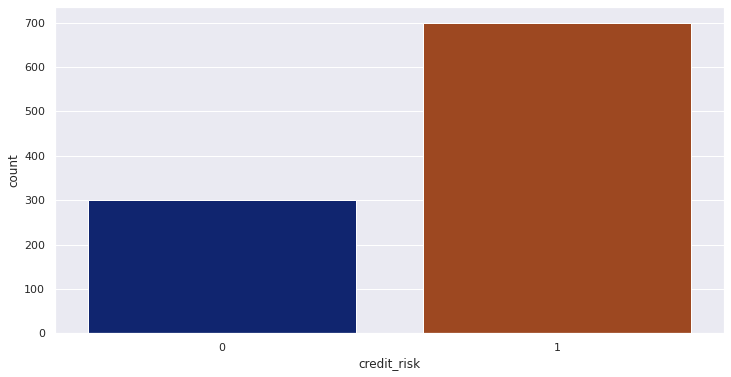

In [8]:
# check if data is unbalanced
sns.countplot(x=df['credit_risk'])

In [9]:
def plot_data(df, target_col):
    for col in df.columns:
        if col == target_col:
            continue
        sns.countplot(x=df[col],hue=df[target_col])
       
        plt.title(col)
        plt.xticks(rotation=45, ha='right')
        plt.show()

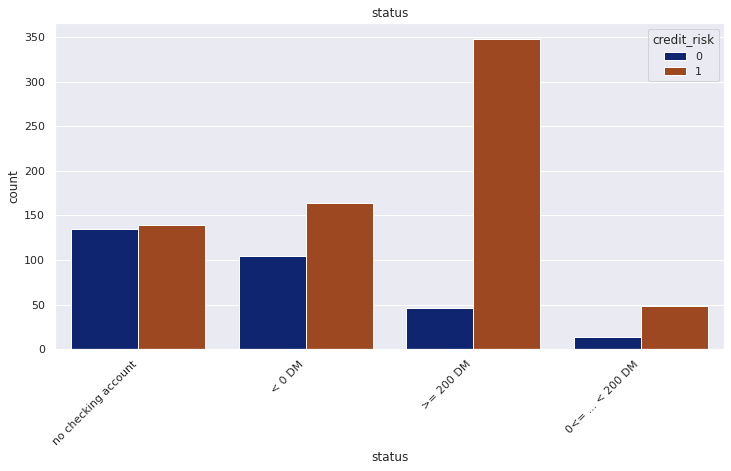

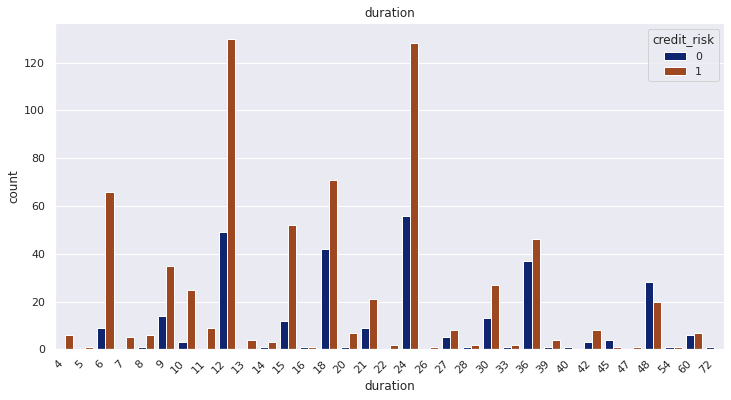

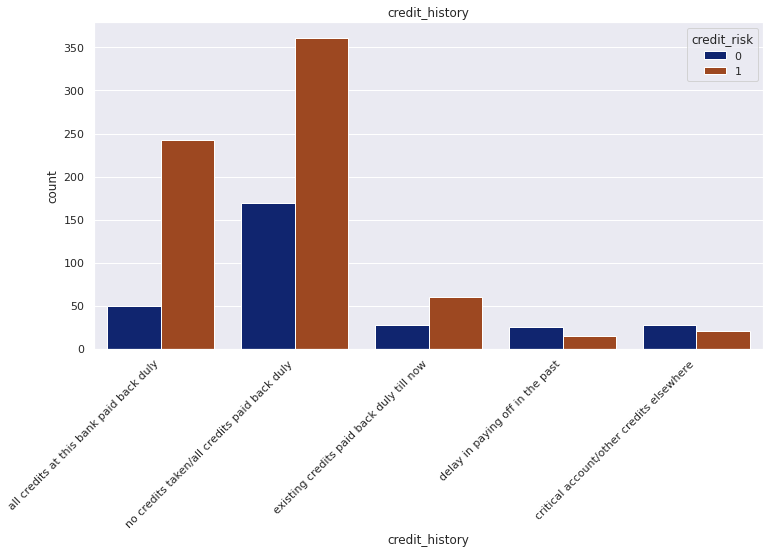

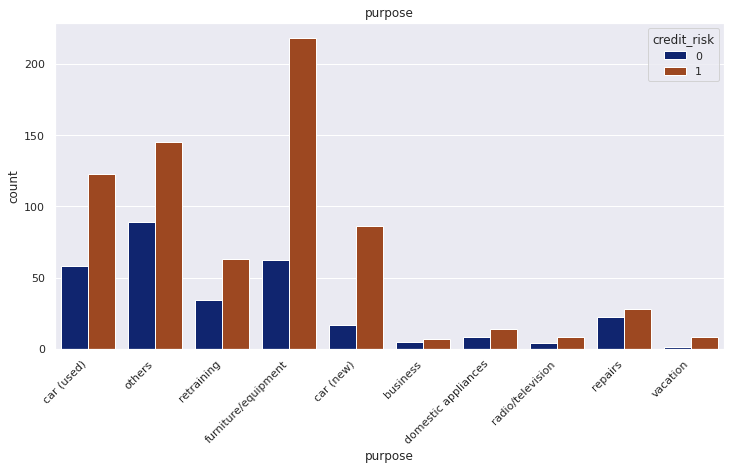

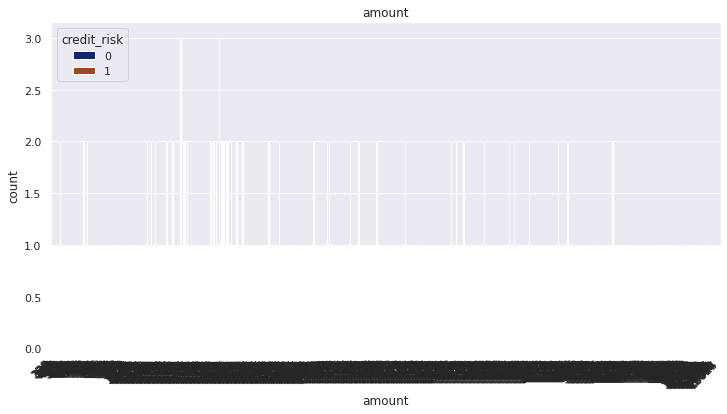

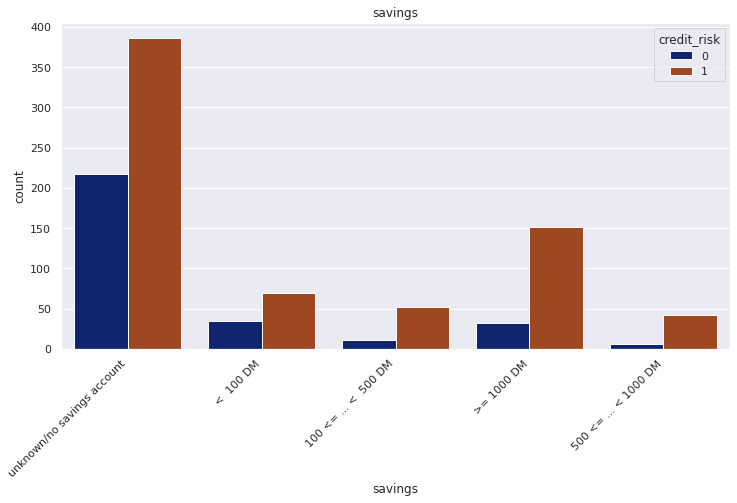

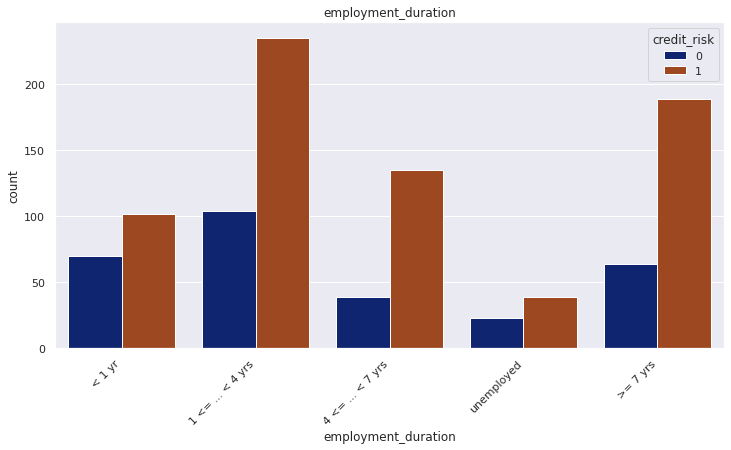

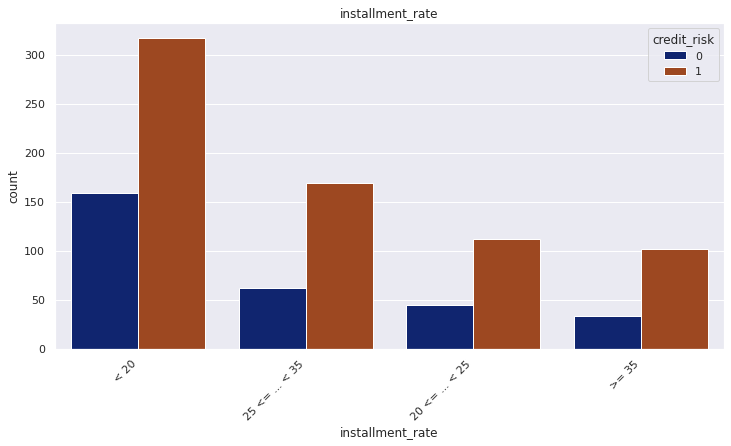

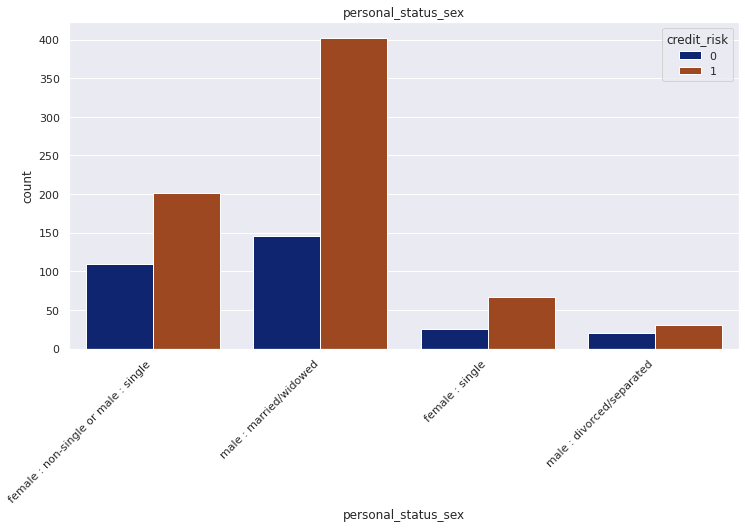

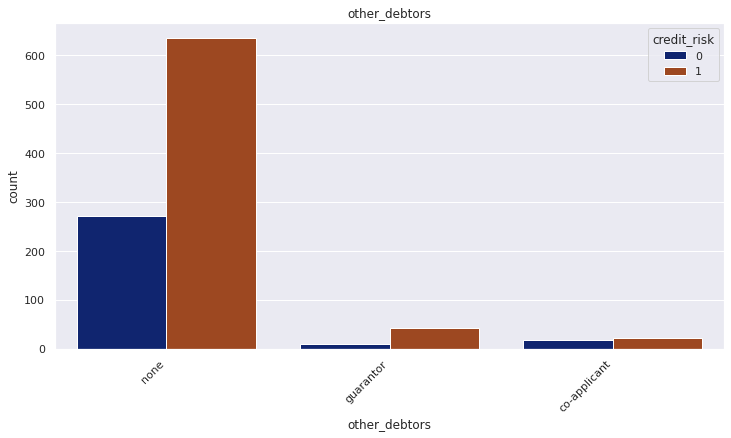

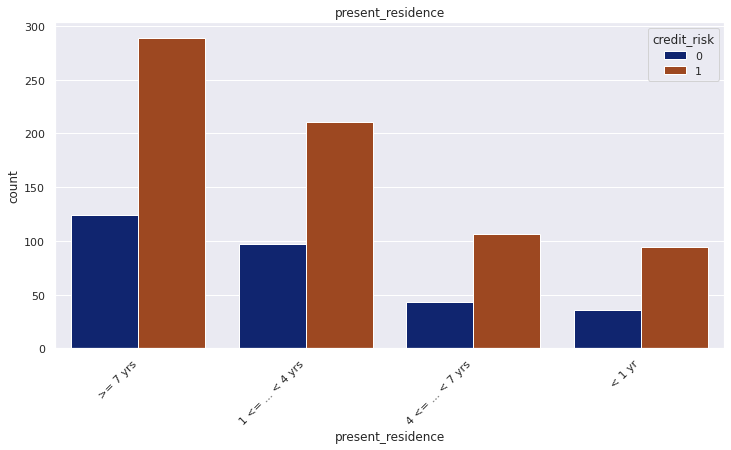

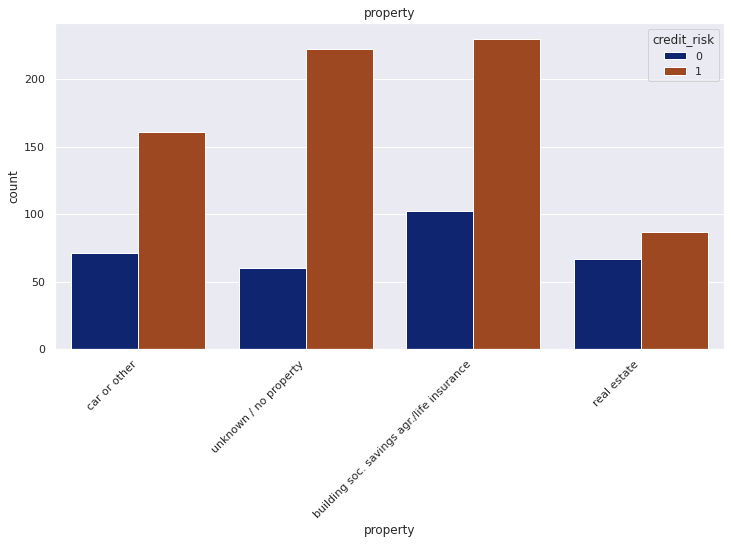

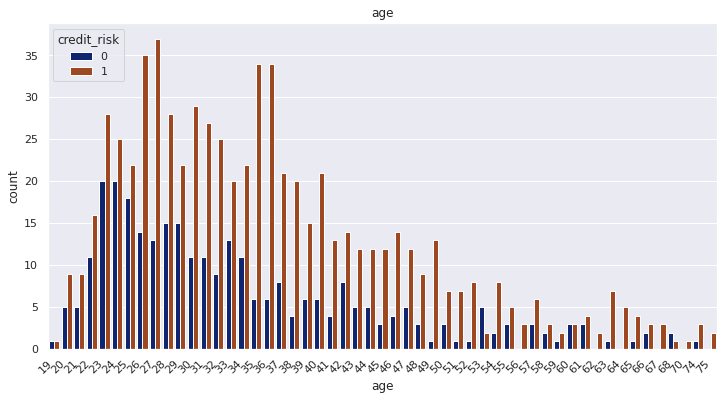

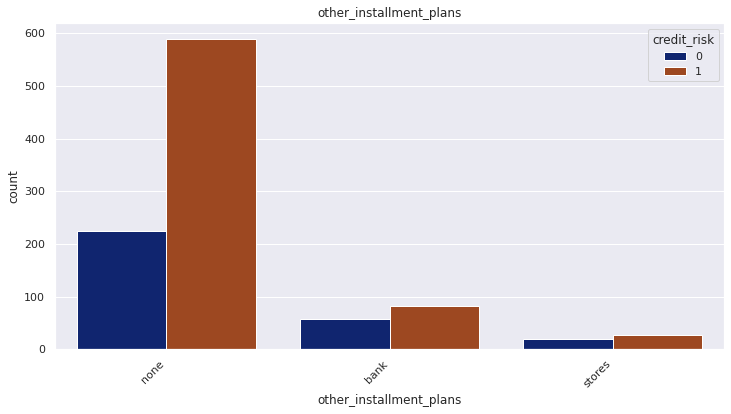

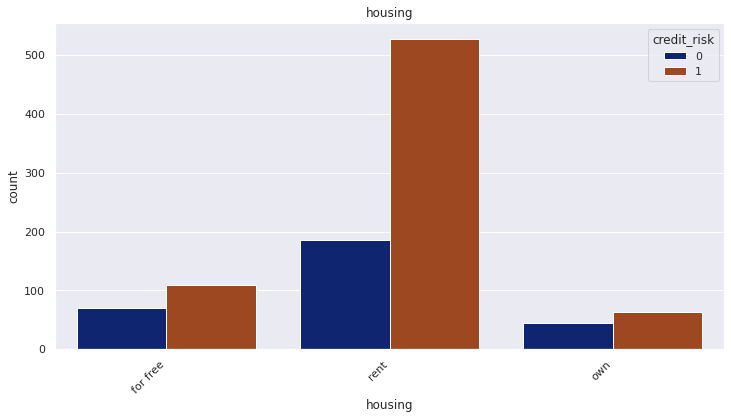

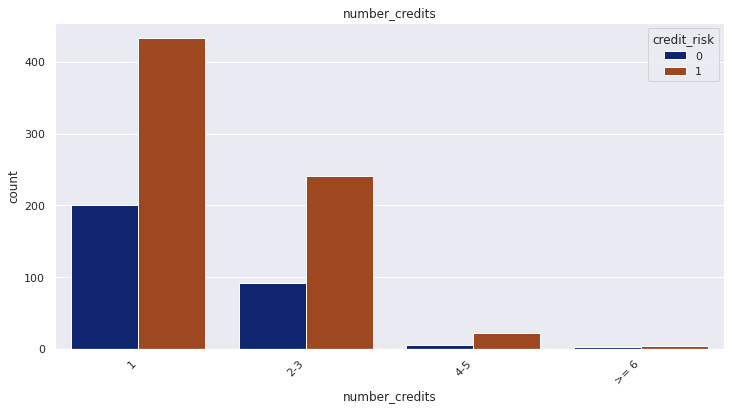

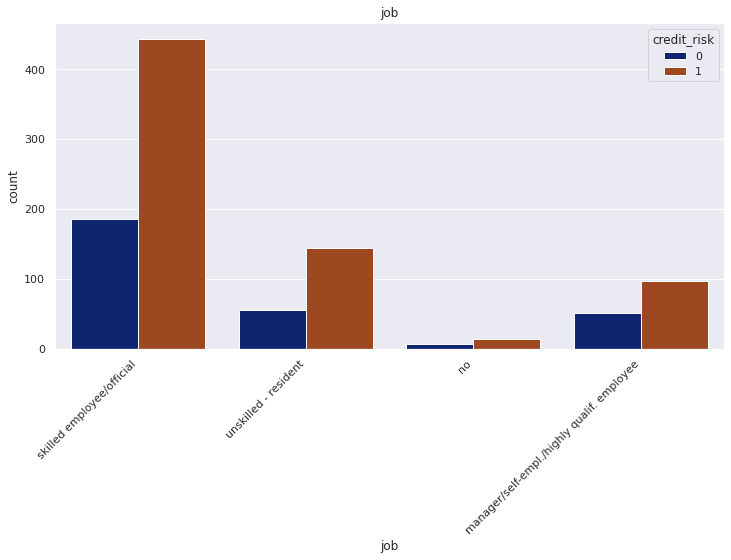

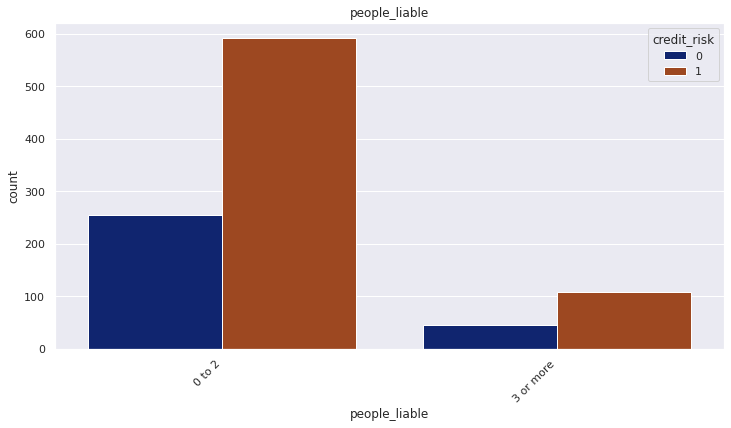

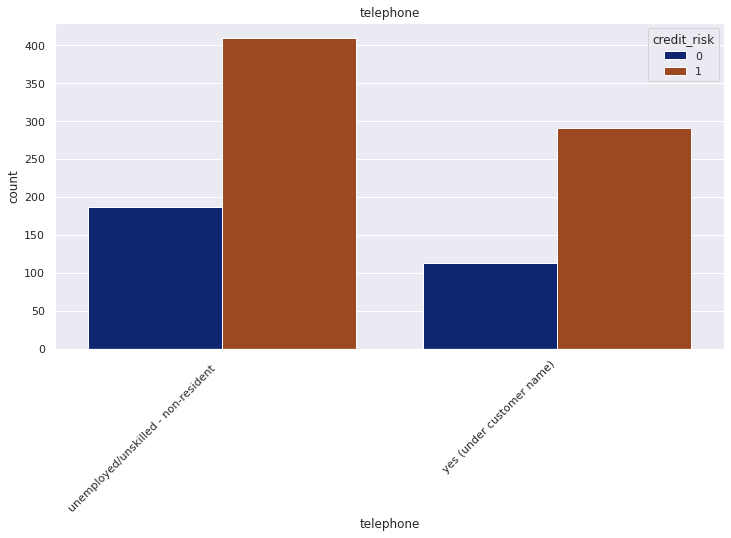

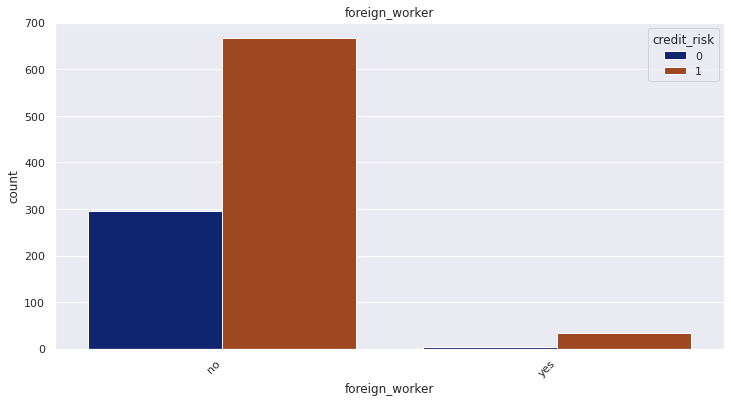

In [10]:
plot_data(df, 'credit_risk')

Plotting age and amount because they are not understandable from above

<Figure size 720x432 with 0 Axes>

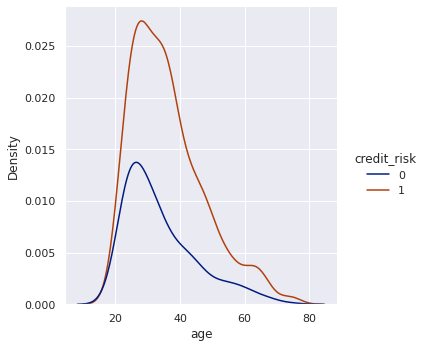

In [11]:
plt.figure(figsize=(10,6))
sns.displot(data=df, x=df["age"], kind="kde", hue=df['credit_risk'])
plt.show()

<Figure size 720x432 with 0 Axes>

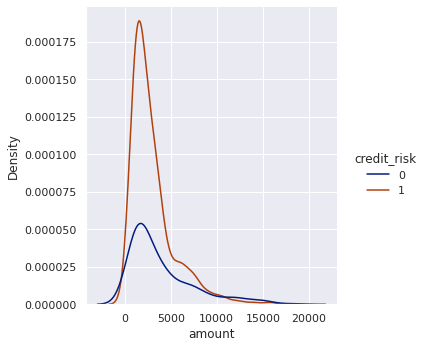

In [12]:
plt.figure(figsize=(10,6))
sns.displot(data=df, x=df["amount"], kind="kde", hue=df['credit_risk'])
plt.show()

---
### <b><i> Obeservations </i></b>

---

1. If you have a good checking account status you are more prone to get a credit
2. Credit history shows that if you had an crdit history and paid it on time or didnt have a credit before you are more prone to get a credit
3. You're more likely to get credit if you have no other installment plants


### ***Bivariate Analysis***
    
---

In [13]:
# init categorical and numerical columns
num_cols = ['duration', 'amount', 'age']
cat_cols = [col for col in df.columns if col not in num_cols]
label= 'credit_risk'

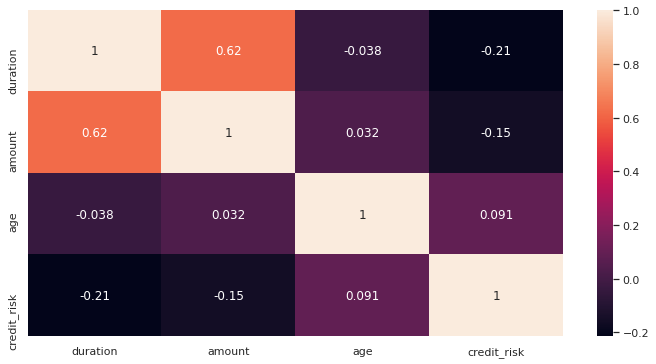

In [14]:
sns.heatmap(df.corr(),annot=True)
plt.show()

In [15]:
cat_df = pd.DataFrame(df, columns=cat_cols.append(label))
features_header= cat_cols
importance_dict = {}

for v in features_header:
    X = cat_df[v].astype(str)
    Y = cat_df[label].astype(str)
    dfObserved = pd.crosstab(Y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    importance_dict[v] = p
    
importance_df = pd.Series(importance_dict)


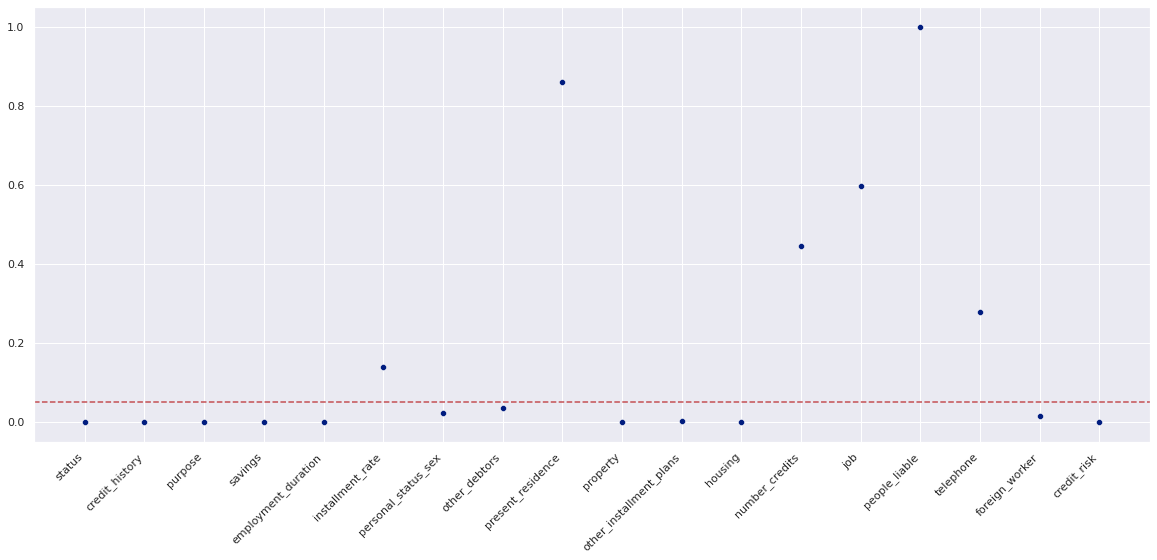

In [16]:
plt.figure(figsize=(20,8))
sns.scatterplot(data=importance_df)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.show()

We can categorize all the features that are below the red line as important and we disregard the feeatures above it. Before we continue to modeling, lets extract only the features we are going to use for our model.

In [17]:
interested_cols = ['amount', 'status', 'credit_history', 'purpose', 'savings', 'employment_duration',  'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans',
                   'housing', 'foreign_worker', 'credit_risk']
model_df = df_original.copy()[interested_cols] # we use the original df since some of the features are already encoded
print(model_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   amount                   1000 non-null   int64
 1   status                   1000 non-null   int64
 2   credit_history           1000 non-null   int64
 3   purpose                  1000 non-null   int64
 4   savings                  1000 non-null   int64
 5   employment_duration      1000 non-null   int64
 6   personal_status_sex      1000 non-null   int64
 7   other_debtors            1000 non-null   int64
 8   property                 1000 non-null   int64
 9   other_installment_plans  1000 non-null   int64
 10  housing                  1000 non-null   int64
 11  foreign_worker           1000 non-null   int64
 12  credit_risk              1000 non-null   int64
dtypes: int64(13)
memory usage: 101.7 KB
None


In [18]:
# we replace the features that are not ordinal and use one hot encoder 
model_df.replace({'credit_history': ch_dict,
           'purpose': purp_dict,
           'personal_status_sex': personal_status_sex_dict, 
           'property': property_dict,
           'other_installment_plans': other_installment_plans_dict,
           },
           inplace=True)

In [19]:
model_df.head()

,amount,status,credit_history,purpose,savings,employment_duration,personal_status_sex,other_debtors,property,other_installment_plans,housing,foreign_worker,credit_risk
0,1049,1,all credits at this bank paid back duly,car (used),1,2,female : non-single or male : single,1,car or other,none,1,2,1
1,2799,1,all credits at this bank paid back duly,others,1,3,male : married/widowed,1,unknown / no property,none,1,2,1
2,841,2,no credits taken/all credits paid back duly,retraining,2,4,female : non-single or male : single,1,unknown / no property,none,1,2,1
3,2122,1,all credits at this bank paid back duly,others,1,3,male : married/widowed,1,unknown / no property,none,1,1,1
4,2171,1,all credits at this bank paid back duly,others,1,3,male : married/widowed,1,car or other,bank,2,1,1


In [20]:
# normalize the numerical cols
num_cols = ['amount','status', 'savings', 'employment_duration', 'other_debtors', 'housing','foreign_worker']

d = preprocessing.normalize(model_df[num_cols], axis=0)
scaled_df = pd.DataFrame(d, columns=num_cols)
model_df.drop(columns=num_cols, inplace=True)
model_df = pd.concat([model_df, scaled_df], axis=1)
model_df.head()

,credit_history,purpose,personal_status_sex,property,other_installment_plans,credit_risk,amount,status,savings,employment_duration,other_debtors,housing,foreign_worker
0,all credits at this bank paid back duly,car (used),female : non-single or male : single,car or other,none,1,0.007679,0.011029,0.012017,0.017602,0.025491,0.015815,0.032071
1,all credits at this bank paid back duly,others,male : married/widowed,unknown / no property,none,1,0.020490,0.011029,0.012017,0.026403,0.025491,0.015815,0.032071
2,no credits taken/all credits paid back duly,retraining,female : non-single or male : single,unknown / no property,none,1,0.006156,0.022058,0.024034,0.035204,0.025491,0.015815,0.032071
3,all credits at this bank paid back duly,others,male : married/widowed,unknown / no property,none,1,0.015534,0.011029,0.012017,0.026403,0.025491,0.015815,0.016035
4,all credits at this bank paid back duly,others,male : married/widowed,car or other,bank,1,0.015892,0.011029,0.012017,0.026403,0.025491,0.031631,0.016035


In [21]:
dummies_cols = ['credit_history', 'purpose', 'personal_status_sex', 'property', 'other_installment_plans']
for col in dummies_cols:
    dummies = pd.get_dummies(model_df[col])
    model_df.drop(columns=[col], inplace=True)
    model_df = pd.concat([model_df, dummies], axis=1)
model_df.head()

,credit_risk,amount,status,savings,employment_duration,other_debtors,housing,foreign_worker,all credits at this bank paid back duly,critical account/other credits elsewhere,...,female : single,male : divorced/separated,male : married/widowed,building soc. savings agr./life insurance,car or other,real estate,unknown / no property,bank,none,stores
0,1,0.007679,0.011029,0.012017,0.017602,0.025491,0.015815,0.032071,1,0,...,0,0,0,0,1,0,0,0,1,0
1,1,0.020490,0.011029,0.012017,0.026403,0.025491,0.015815,0.032071,1,0,...,0,0,1,0,0,0,1,0,1,0
2,1,0.006156,0.022058,0.024034,0.035204,0.025491,0.015815,0.032071,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1,0.015534,0.011029,0.012017,0.026403,0.025491,0.015815,0.016035,1,0,...,0,0,1,0,0,0,1,0,1,0
4,1,0.015892,0.011029,0.012017,0.026403,0.025491,0.031631,0.016035,1,0,...,0,0,1,0,1,0,0,1,0,0


---
## ***Modeling***
---

In [22]:
X = model_df.drop(columns=['credit_risk'])
y = model_df['credit_risk']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8) # 80 % train, 20% test

#### SVM

In [24]:
svc = SVC(probability=True)

svm_parameters = {
    'kernel': ('rbf', 'linear'),
    'C': [1, 10]
}

In [25]:
# grid search to find the best parameters 
# RUNNING TAKES A LOT OF TIME
svm_clf = GridSearchCV(svc, svm_parameters).fit(X_train, y_train)

#### Logistic Regression

In [26]:
lr = LogisticRegression(max_iter=10000)

lr_parameters = {
    'penalty': ('none', 'l2')
}

In [27]:
lr_clf = GridSearchCV(lr, lr_parameters).fit(X_train, y_train)

#### Random Forest Classification

In [28]:
rfc = RandomForestClassifier()

rfc_parameters = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy']
}

In [29]:
rfc_clf = GridSearchCV(rfc, rfc_parameters).fit(X_train, y_train)

#### ***Best parameters***

In [30]:
# get the best parameters for the classifiers
#svm_model = svm_clf.best_estimator_
svm_model = svm_clf.best_estimator_
lr_model = lr_clf.best_estimator_
rfc_model = rfc_clf.best_estimator_

---
### ***Evaluation***
---

In [31]:
# predictions
svm_pred = svm_model.predict(X_test)
svm_score = svm_model.score(X_test, y_test)
print("Support Vector machine accuracy:", svm_score*100)

lr_pred = lr_model.predict(X_test)
lr_score = lr_model.score(X_test, y_test)
print("Logistic regression accuracy:", lr_score*100)

rfc_pred = rfc_model.predict(X_test)
rfc_score = rfc_model.score(X_test, y_test)
print("Random Forest Classifier accuracy:", rfc_score*100)

Support Vector machine accuracy: 75.5
Logistic regression accuracy: 80.5
Random Forest Classifier accuracy: 75.5


In [32]:
model_res = {
    svm_model: svm_pred,
    lr_model: lr_pred,
    rfc_model: rfc_pred
}

In [33]:
def plot_roc(model, X_test, y_test):
    class_probabilities = model.predict_proba(X_test)
    preds = class_probabilities[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # Printing AUC
    print(f"AUC for our classifier is: {roc_auc}")

    # Plotting the ROC
    plt.title(f'Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

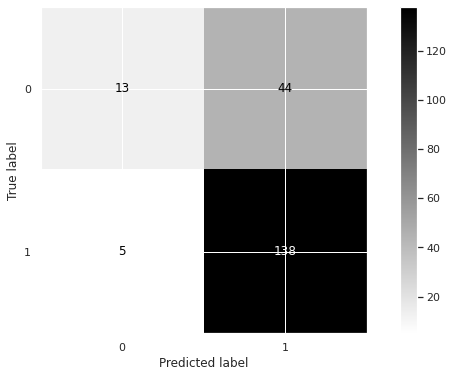

              precision    recall  f1-score   support

           0       0.72      0.23      0.35        57
           1       0.76      0.97      0.85       143

    accuracy                           0.76       200
   macro avg       0.74      0.60      0.60       200
weighted avg       0.75      0.76      0.71       200

AUC for our classifier is: 0.8111888111888113


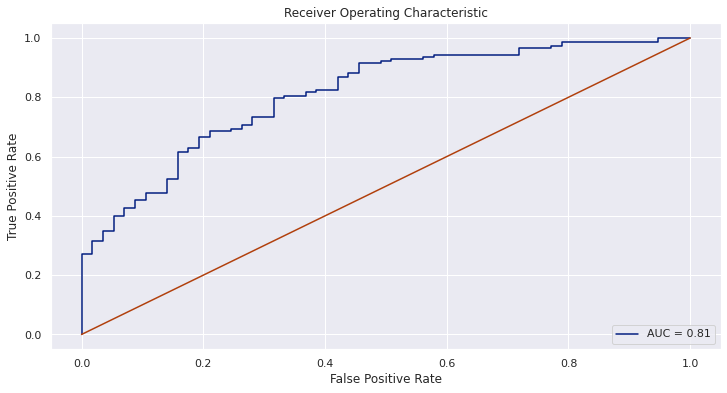

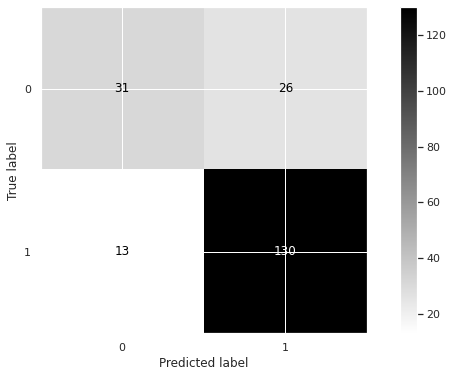

              precision    recall  f1-score   support

           0       0.70      0.54      0.61        57
           1       0.83      0.91      0.87       143

    accuracy                           0.81       200
   macro avg       0.77      0.73      0.74       200
weighted avg       0.80      0.81      0.80       200

AUC for our classifier is: 0.8165869218500797


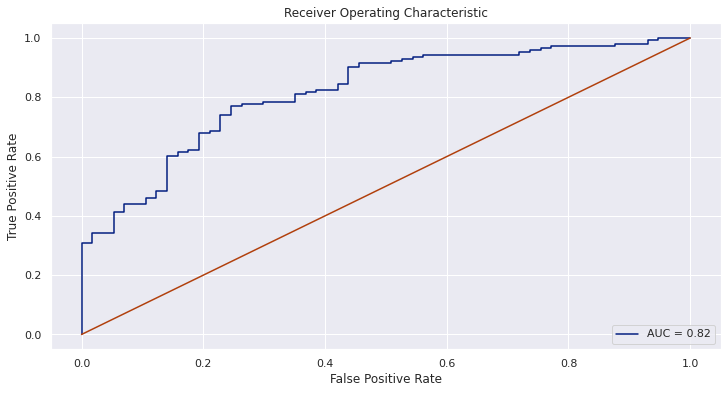

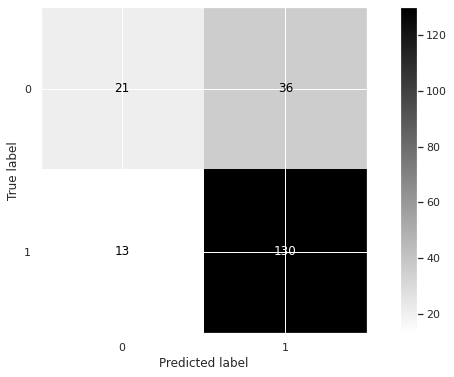

              precision    recall  f1-score   support

           0       0.62      0.37      0.46        57
           1       0.78      0.91      0.84       143

    accuracy                           0.76       200
   macro avg       0.70      0.64      0.65       200
weighted avg       0.74      0.76      0.73       200

AUC for our classifier is: 0.7697828487302172


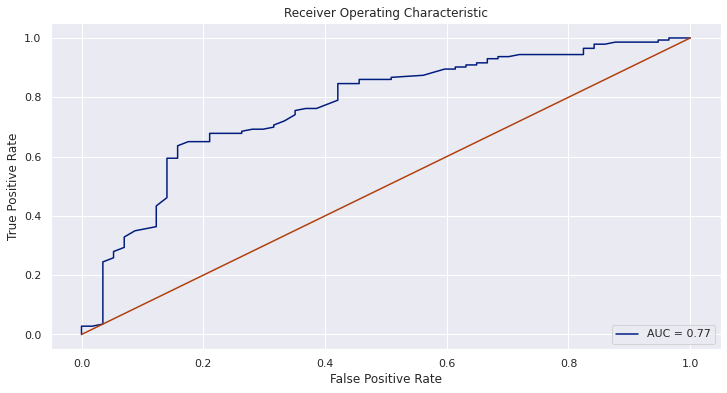

In [34]:
for model, pred in model_res.items():
    plot_confusion_matrix(model, X_test, y_test, cmap='binary')
    plt.show()
    print(classification_report(y_test, pred))
    plot_roc(model, X_test, y_test)

## <center>2. Reproducing Results</center> 

Loading and processing of the data

In [35]:
german_credits_df = pd.read_csv('german_processed.csv')
german_credits_df=german_credits_df.drop("Unnamed: 0",axis=1)

dummies_cols = ['Status', 'Credit history', 'Purpose', 'Savings account/bonds'
                , 'Employment','Status and sex','Other debtors/guarantors','Property'
                ,'Other installment plans','Housing'
                ,'Job','Telephone','Foreign worker']
for col in dummies_cols:
    dummies = pd.get_dummies(german_credits_df[col])
    german_credits_df.drop(columns=[col], inplace=True)
    german_credits_df = pd.concat([german_credits_df, dummies], axis=1)

Spliting data i.e. train = 90 %

In [36]:
X = german_credits_df.drop(columns=['label'])
y = german_credits_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.90)

Cross-validation and training 

In [37]:
kf = KFold(n_splits=10, random_state=None)
model = LogisticRegression(max_iter=10000)
acc_score = []
best_acc=0
best_model=0
for train_index , val_index in kf.split(X_train):
    X_train , X_val = X.iloc[train_index,:],X.iloc[val_index,:]
    y_train , y_val = y[train_index] , y[val_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_val)
    
    acc = accuracy_score(pred_values , y_val)
    if acc > best_acc:
        best_model= model
    acc_score.append(acc)

In [38]:
print('accuracy of each fold - {}'.format(acc_score))

accuracy of each fold - [0.8444444444444444, 0.7444444444444445, 0.6888888888888889, 0.7222222222222222, 0.7333333333333333, 0.8, 0.6333333333333333, 0.7333333333333333, 0.8111111111111111, 0.7444444444444445]


Testing on test data as well

In [39]:
pred_values = best_model.predict(X_test)
accuracy_score(pred_values , y_test)

0.81

In [40]:
coef = best_model.coef_

In [41]:
print(
    "Personal status and gender: single male:", coef[0, X_train.columns.get_loc('male: single')],
    "\nPersonal status and gender: married male:", coef[0, X_train.columns.get_loc('male: married/widowed')],
    "\nPersonal status and gender: married/divorced female:", coef[0, X_train.columns.get_loc('female: divorced/separated/married')],
    "\nPersonal status and gender: divorced male", coef[0, X_train.columns.get_loc(' male: divorced/separated')]
)

Personal status and gender: single male: -0.7513618053472774 
Personal status and gender: married male: -0.17901366050994508 
Personal status and gender: married/divorced female: -0.04293372799655683 
Personal status and gender: divorced male 0.41802073714018195
